In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore

def process_cell_types(adata_object):
    """
    Process cell type names to match the validation set.
    Logic: Merge 'excitatory' and 'inhibitory' neurons into 'neurons'.
    """
    # Ensure data is read as string type, removing numpy.str_ effects
    raw_cell_types = adata_object.obs['celltype'].astype(str).values
    
    cell_type_cpu = np.array(raw_cell_types)
    
    # --- Logic from scReGAT paper ---
    # Unify excitatory and inhibitory neurons into 'neurons'
    # Note: Using list comprehension to generate indices
    cell_type_cpu[[idx for idx, t in enumerate(cell_type_cpu) if t.startswith('excitatory_neuron')]] = 'neurons'
    cell_type_cpu[[idx for idx, t in enumerate(cell_type_cpu) if t.startswith('inhibitory_neuron')]] = 'neurons'
    
    unique_types = np.unique(cell_type_cpu)
    print(f"[INFO] Processed cell type list: {unique_types}")
    
    return cell_type_cpu, unique_types

def plot_regulatory_scores_box(rs_matrix, edge_indices, cell_types, target_celltype, palette=None, title=None):
    """
    Generate box plots replicating the style of Figure 1e (without P-values).
    """
    unique_types = np.unique(cell_types)
    
    # 1. Z-score Normalization (Comparing relative intensity)
    selected_scores = rs_matrix[:, edge_indices]
    z_scores = zscore(selected_scores, axis=0)
    z_scores = np.nan_to_num(z_scores)

    # 2. Aggregate Scores (Mean of edges -> Median of cells)
    plot_data = []
    mean_vals = []
    
    for ct in unique_types:
        cells_mask = (cell_types == ct)
        if np.sum(cells_mask) == 0: continue
            
        # Calculate mean score across selected edges for each cell
        ct_cell_scores = z_scores[cells_mask].mean(axis=1)
        mean_vals.append(np.median(ct_cell_scores))
        
        # Clip outliers for better visualization (Clip to -1, 1)
        ct_scores_clipped = np.clip(ct_cell_scores, -1, 1)
        
        df_temp = pd.DataFrame({
            'Regulatory Score': ct_scores_clipped,
            'Cell Type': ct
        })
        plot_data.append(df_temp)
        
    df_plot = pd.concat(plot_data)
    
    # 3. Sorting: Target cell type first, others sorted by median descending
    other_types = [ct for ct in unique_types if ct != target_celltype]
    sorted_others = sorted(other_types, key=lambda x: mean_vals[list(unique_types).index(x)], reverse=True)
    order = [target_celltype] + sorted_others
    
    # 4. Plotting
    plt.figure(figsize=(5, 5.5))
    
    # Check if palette covers all keys
    missing_keys = set(order) - set(palette.keys())
    if missing_keys:
        print(f"[WARN] Palette missing keys, using defaults for: {missing_keys}")
    
    sns.boxplot(
        x='Cell Type', 
        y='Regulatory Score', 
        data=df_plot, 
        order=order,
        palette=palette,
        showfliers=False, 
        width=0.6,
        linewidth=1.5,
        whis=1.5
    )
    
    plt.title(title if title else f"{target_celltype.capitalize()}-specific RRs", fontsize=16, weight='bold', pad=15)
    plt.ylabel("Scaled RS Values", fontsize=14, weight='bold')
    plt.xlabel("")
    plt.xticks(rotation=45, ha='right', fontsize=12, weight='bold')
    plt.yticks(fontsize=12)
    plt.ylim(-1.2, 1.6)
    
    sns.despine(trim=True)
    plt.tight_layout()
    plt.show()


/opt/conda/envs/scReGAT/lib/python3.10/site-packages/anndata/_metadata.py:15: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Loading model results from ./MFG_RS_score.h5ad...
[INFO] Processed cell type list: ['astrocyte' 'microglia' 'neurons' 'oligodendrocytes' 'polydendrocytes']

Analyzing microglia...
  -> Found 1762 overlapping edges.


/tmp/ipykernel_23671/1943328115.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


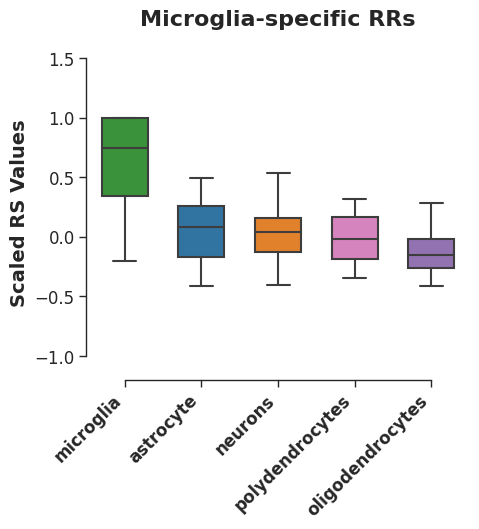


Analyzing neurons...
  -> Found 2577 overlapping edges.


/tmp/ipykernel_23671/1943328115.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


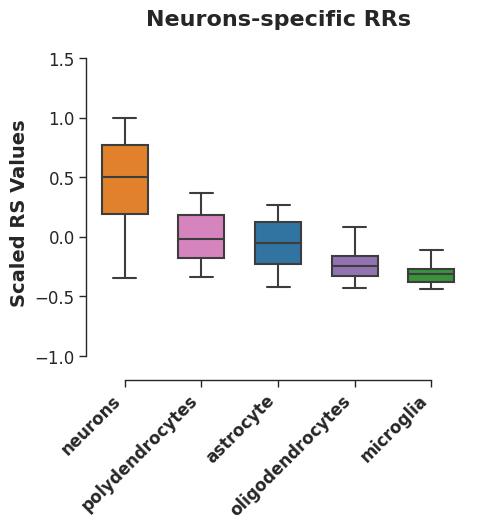


Analyzing oligodendrocytes...
  -> Found 2440 overlapping edges.


/tmp/ipykernel_23671/1943328115.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


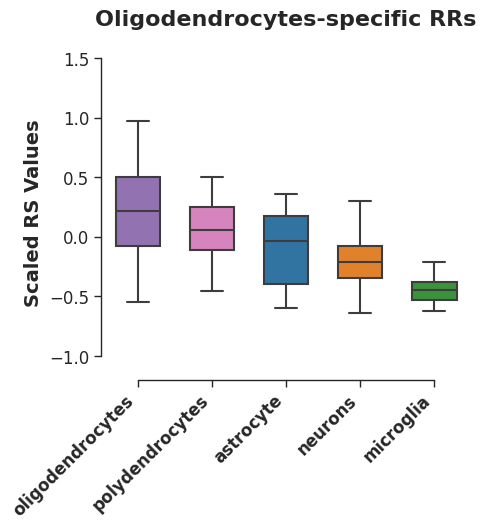

In [2]:


# ==========================================
# Plotting Style Settings (Publication-Quality)
# ==========================================
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
sns.set_context("paper", font_scale=1.4)
sns.set_style("ticks")


# ==========================================
# Main Execution Module
# ==========================================

# --- A. Set Paths ---
# Please ensure data_dir points to the parent directory of your specific files
data_dir = "./scReGAT/data/celltype_specific_cRE_interactions/"  # <--- Modify this path according to your actual environment
validated_edges_dir = os.path.join(data_dir, "") 
h5ad_path = os.path.join("./MFG_RS_score.h5ad")

# --- B. Load Data ---
if os.path.exists(h5ad_path):
    print(f"Loading model results from {h5ad_path}...")
    adata_edge = sc.read_h5ad(h5ad_path)
    adata = adata_edge
    res_edge = adata_edge.X 

    # --- C. Process Cell Types ---
    cell_type_cpu, unique_celltype = process_cell_types(adata_edge)
    
    # --- D. Define Color Palette ---
    # Added 'astrocyte' and 'polydendrocytes' based on potential data content
    paper_palette = {
        'microglia': '#2ca02c',          # Green
        'neurons': '#ff7f0e',            # Orange
        'oligodendrocytes': '#9467bd',   # Purple
        'astrocyte': '#1f77b4',          # Blue 
        'polydendrocytes': '#e377c2',    # Pink 
        'unknown': '#7f7f7f'             # Grey
    }
    
    # --- E. Iterate and Plot ---
    # Based on the previous context, we focus on these three specific types
    target_list = ["microglia", "neurons", "oligodendrocytes"]
    
    for c_type in target_list:
        file_name = f"base_edge_{c_type}.txt"
        file_path = os.path.join(validated_edges_dir, file_name)
        
        if os.path.exists(file_path):
            print(f"\nAnalyzing {c_type}...")
            
            # Read validation set (col 0=peak, col 1=gene)
            edge_base = pd.read_csv(file_path, header=None, sep='\t', names=['peak', 'gene'])
            edge_base['edge_id'] = edge_base['peak'].astype(str) + "_" + edge_base['gene'].astype(str)
            
            # Find overlapping edges
            valid_indices = np.where(adata_edge.var_names.isin(edge_base['edge_id']))[0]
            print(f"  -> Found {len(valid_indices)} overlapping edges.")
            
            if len(valid_indices) > 0:
                plot_regulatory_scores_box(
                    rs_matrix=res_edge,
                    edge_indices=valid_indices,
                    cell_types=cell_type_cpu,
                    target_celltype=c_type,
                    palette=paper_palette,
                    title=f"{c_type.capitalize()}-specific RRs"
                )
        else:
            print(f"[WARN] File not found: {file_path}")
            print("Please check if 'validated_edges_dir' correctly points to the folder containing .txt files.")
else:
    print(f"[ERROR] .h5ad data file not found: {h5ad_path}")


In [3]:
adata.var

Empty DataFrame
Columns: []
Index: [chr1-1432429-1432929_VWA1, chr1-1433094-1433707_VWA1, chr1-1434222-1434722_VWA1, chr1-1435340-1435840_VWA1, chr1-3068905-3069405_PRDM16, chr1-3069568-3070068_PRDM16, chr1-9997680-9998180_RBP7, chr1-10449381-10450457_CORT, chr1-10450573-10451073_CORT, chr1-10451229-10451729_CORT, chr1-12166753-12167253_TNFRSF1B, chr1-12167487-12167987_TNFRSF1B, chr1-12168037-12168537_TNFRSF1B, chr1-13583981-13584805_PDPN, chr1-13585127-13585853_PDPN, chr1-13892262-13893382_KAZN, chr1-13893484-13893984_KAZN, chr1-13894009-13894509_KAZN, chr1-17117607-17118107_PADI2, chr1-17118181-17119079_PADI2, chr1-17119310-17120176_PADI2, chr1-18902448-18903282_ALDH4A1, chr1-22636297-22637089_C1QA, chr1-22642005-22642505_C1QC, chr1-22642781-22643281_C1QC, chr1-22645544-22646044_C1QC, chr1-22652637-22653272_C1QB, chr1-23559462-23559962_ID3, chr1-23561591-23562091_ID3, chr1-24743511-24744011_CLIC4, chr1-24744768-24745515_CLIC4, chr1-25543291-25543950_LDLRAP1, chr1-25544341-25545232_LDLRAP1, chr1-30756521-30757021_LAPTM5, chr1-30757239-30757739_LAPTM5, chr1-30909379-30909879_SDC3, chr1-32335045-32335545_MARCKSL1, chr1-32336034-32337025_MARCKSL1, chr1-32337851-32339035_MARCKSL1, chr1-36123108-36124229_COL8A2, chr1-38004467-38004967_FHL3, chr1-39786653-39787153_BMP8B, chr1-39788655-39789155_BMP8B, chr1-39952490-39953220_MFSD2A, chr1-39953619-39954119_MFSD2A, chr1-39954863-39955363_MFSD2A, chr1-39955552-39956052_MFSD2A, chr1-40314785-40317051_COL9A2, chr1-42957939-42959563_SLC2A1, chr1-42961158-42961658_SLC2A1, chr1-43271215-43271765_TMEM125, chr1-43302036-43302536_TIE1, chr1-43302550-43303050_TIE1, chr1-43367816-43369104_ELOVL1, chr1-44029570-44030940_SLC6A9, chr1-44404936-44405674_RNF220, chr1-44405934-44406434_RNF220, chr1-46616056-46616556_MOB3C, chr1-46616593-46617376_MOB3C, chr1-47231464-47231964_TAL1, chr1-48470168-48471282_SPATA6, chr1-48471480-48472704_SPATA6, chr1-50022856-50023549_AGBL4, chr1-50023652-50024748_AGBL4, chr1-51990505-51991005_RAB3B, chr1-53326064-53326670_LRP8, chr1-53326880-53327380_LRP8, chr1-53327409-53327909_LRP8, chr1-53327986-53328486_LRP8, chr1-54541860-54542848_ACOT11, chr1-58545608-58546434_DAB1, chr1-58546575-58547120_DAB1, chr1-58699741-58700468_MYSM1, chr1-59925682-59926182_CYP2J2, chr1-59926499-59927631_CYP2J2, chr1-60865225-60866841_NFIA, chr1-68231455-68232772_WLS, chr1-72281119-72281619_NEGR1, chr1-72281987-72282591_NEGR1, chr1-72282787-72284260_NEGR1, chr1-72284347-72284847_NEGR1, chr1-76867236-76868078_ST6GALNAC5, chr1-76868175-76868840_ST6GALNAC5, chr1-76869002-76869502_ST6GALNAC5, chr1-77280892-77282979_AK5, chr1-77283986-77284486_AK5, chr1-78617435-78618066_IFI44L, chr1-78618926-78619426_IFI44L, chr1-78619481-78620067_IFI44L, chr1-78620247-78621181_IFI44L, chr1-78649506-78650489_IFI44, chr1-78650956-78651456_IFI44, chr1-81305978-81306525_ADGRL2, chr1-86154486-86155149_COL24A1, chr1-86156103-86156784_COL24A1, chr1-86156900-86157714_COL24A1, chr1-86546346-86547280_CLCA4, chr1-86547478-86548195_CLCA4, chr1-86548754-86549254_CLCA4, chr1-87327528-87328779_LMO4, ...]

[69180 rows x 0 columns]

/opt/conda/envs/scReGAT/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/conda/envs/scReGAT/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/scReGAT/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


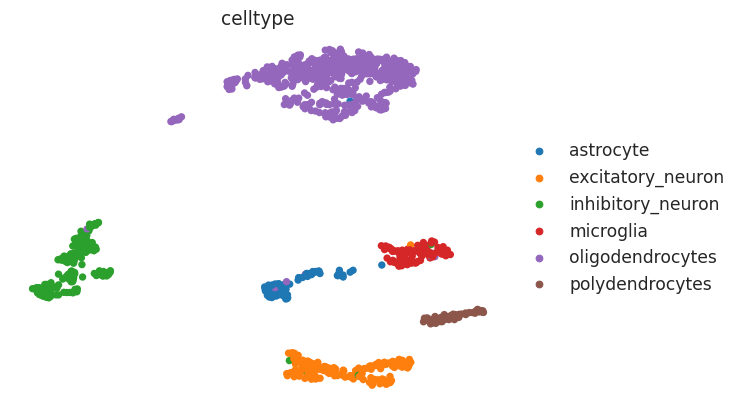

In [4]:
from sklearn.metrics import silhouette_score
import numpy as np
import scanpy as sc
from sklearn.metrics import silhouette_score
score = 0
ris_adata = adata_edge.copy()

# Loading the data
adata = ris_adata 
adata.X[adata.X<0] = 0

# Log-transform the data after normalization
sc.pp.normalize_total(adata, target_sum=1e4) 
sc.pp.log1p(adata)

# Identifying highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor='seurat')

# Subset the adata to only highly variable genes
adata = adata[:, adata.var.highly_variable]

# Scaling the data (optional, but often useful for PCA and clustering)
sc.pp.scale(adata, max_value=10)

# Running PCA to reduce dimensions
sc.tl.pca(adata, svd_solver='arpack', n_comps=30)

# Finding neighbors for clustering (based on PCA components)
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=30, metric="cosine")

# Running UMAP for visualization
sc.tl.umap(adata, min_dist=0.5)

# Visualizing the UMAP plot with color based on 'celltype'
sc.pl.umap(adata, color=['celltype'], wspace=0.5, frameon=False)


Loading data from ./MFG_RS_score.h5ad...
Data loaded and gene names extracted.

--- Section 2: Gene-Level Aggregation & Dotplot ---
Aggregating edge scores to gene level...
[INFO] The following markers were not found in edge targets and will be excluded: ['CSF1R', 'NEUROD6']
Filtering marker genes dictionary for plotting...
Plotting Gene-Level Regulatory Dotplot...


/opt/conda/envs/scReGAT/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)
/tmp/ipykernel_23671/2263826392.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1200x900 with 0 Axes>

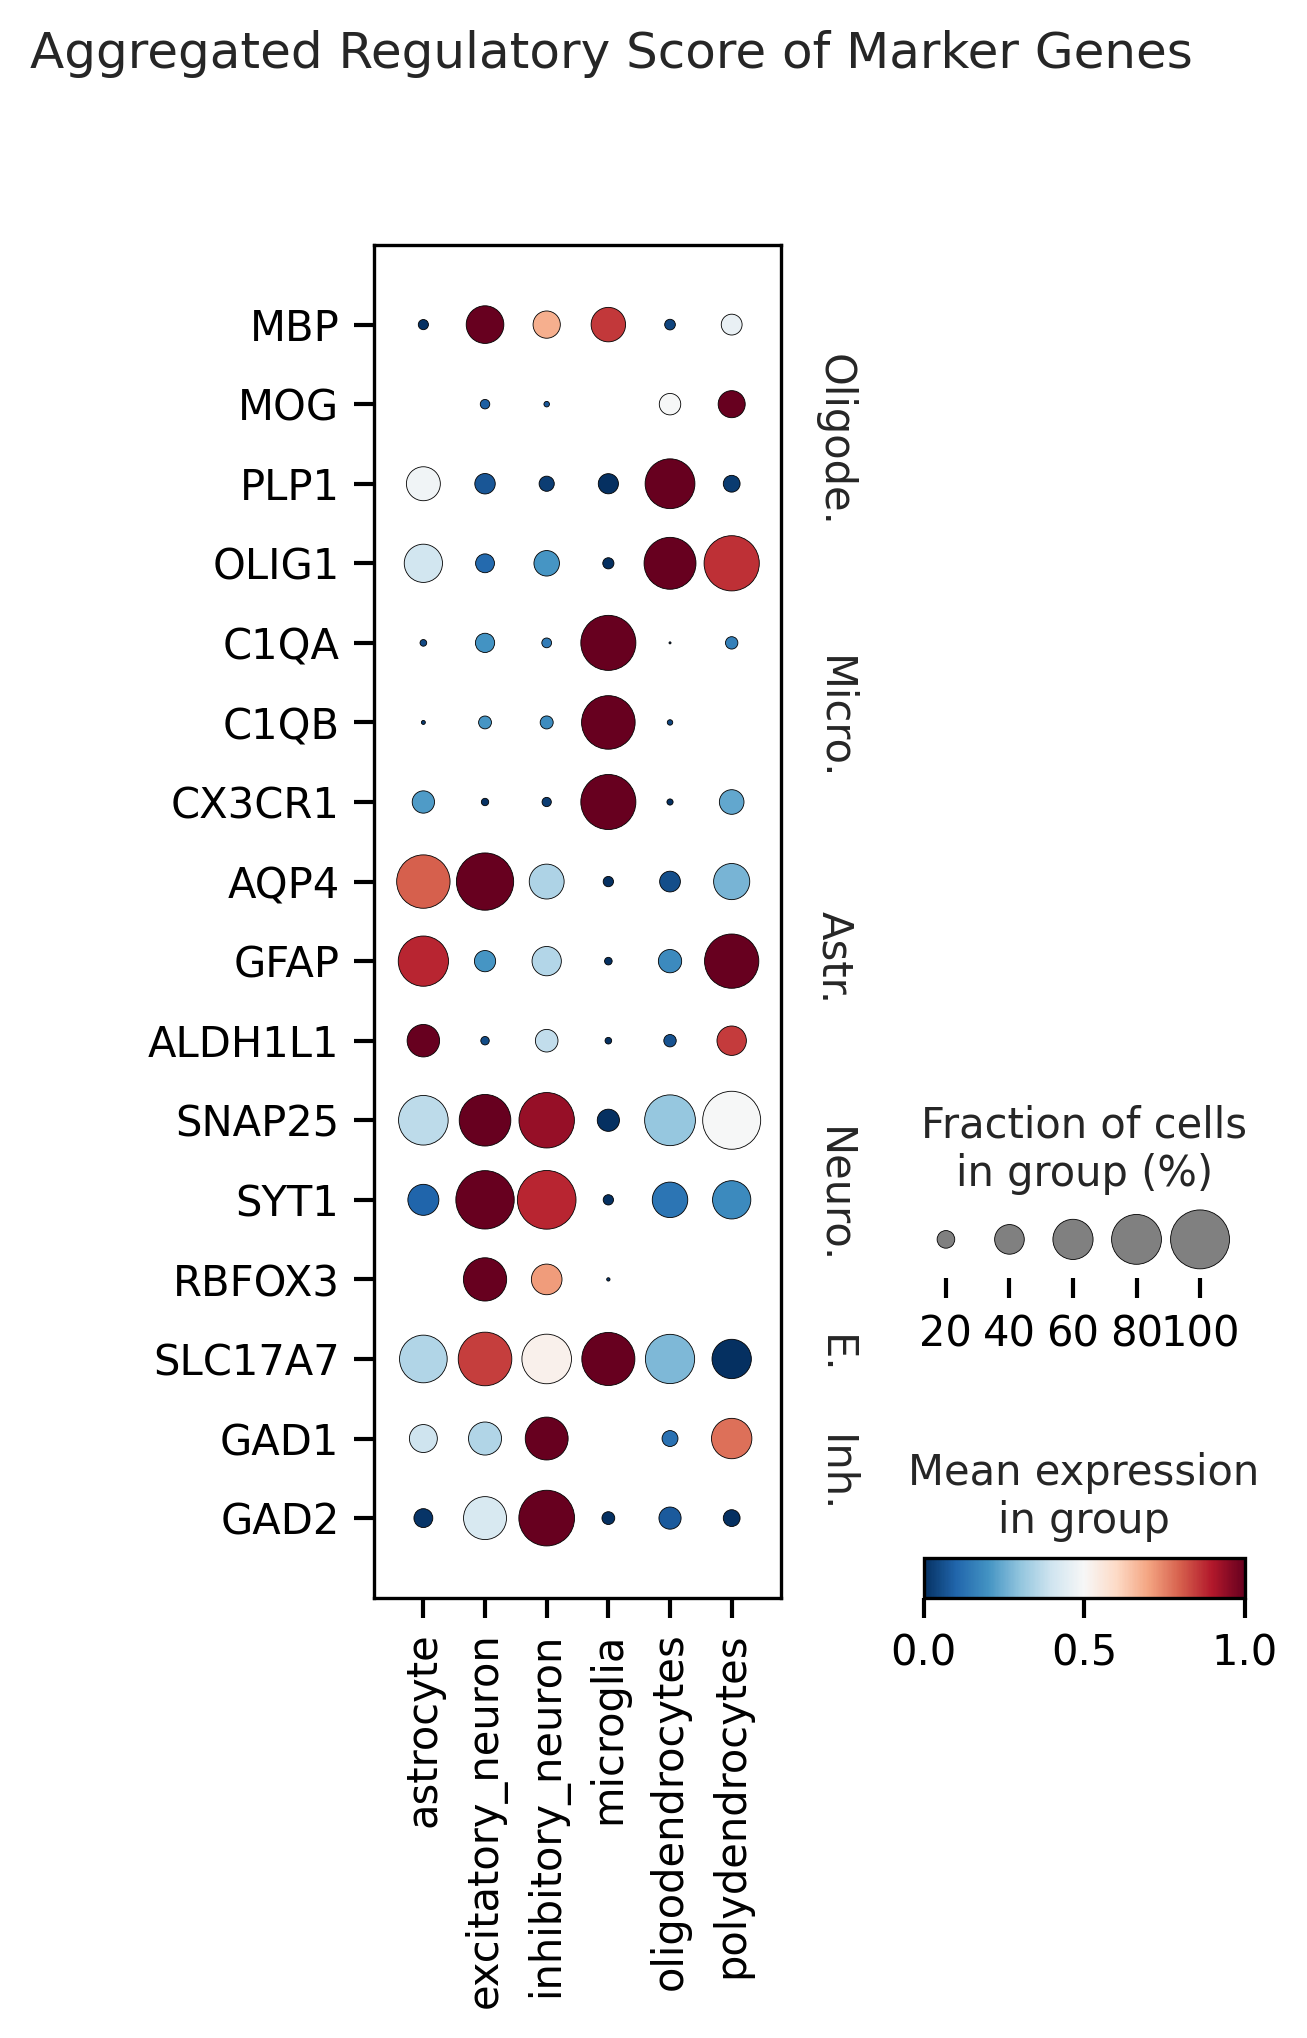


--- Section 3: Differential Edge Analysis ---
Calculating differential edges (Wilcoxon rank-sum)...


/opt/conda/envs/scReGAT/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/conda/envs/scReGAT/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/conda/envs/scReGAT/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/conda/envs/scReGAT/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/conda/envs/scReGAT/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/conda/envs

         Falling back to preprocessing with `sc.pp.pca` and default params.


/tmp/ipykernel_23671/2263826392.py:126: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1200x1500 with 0 Axes>

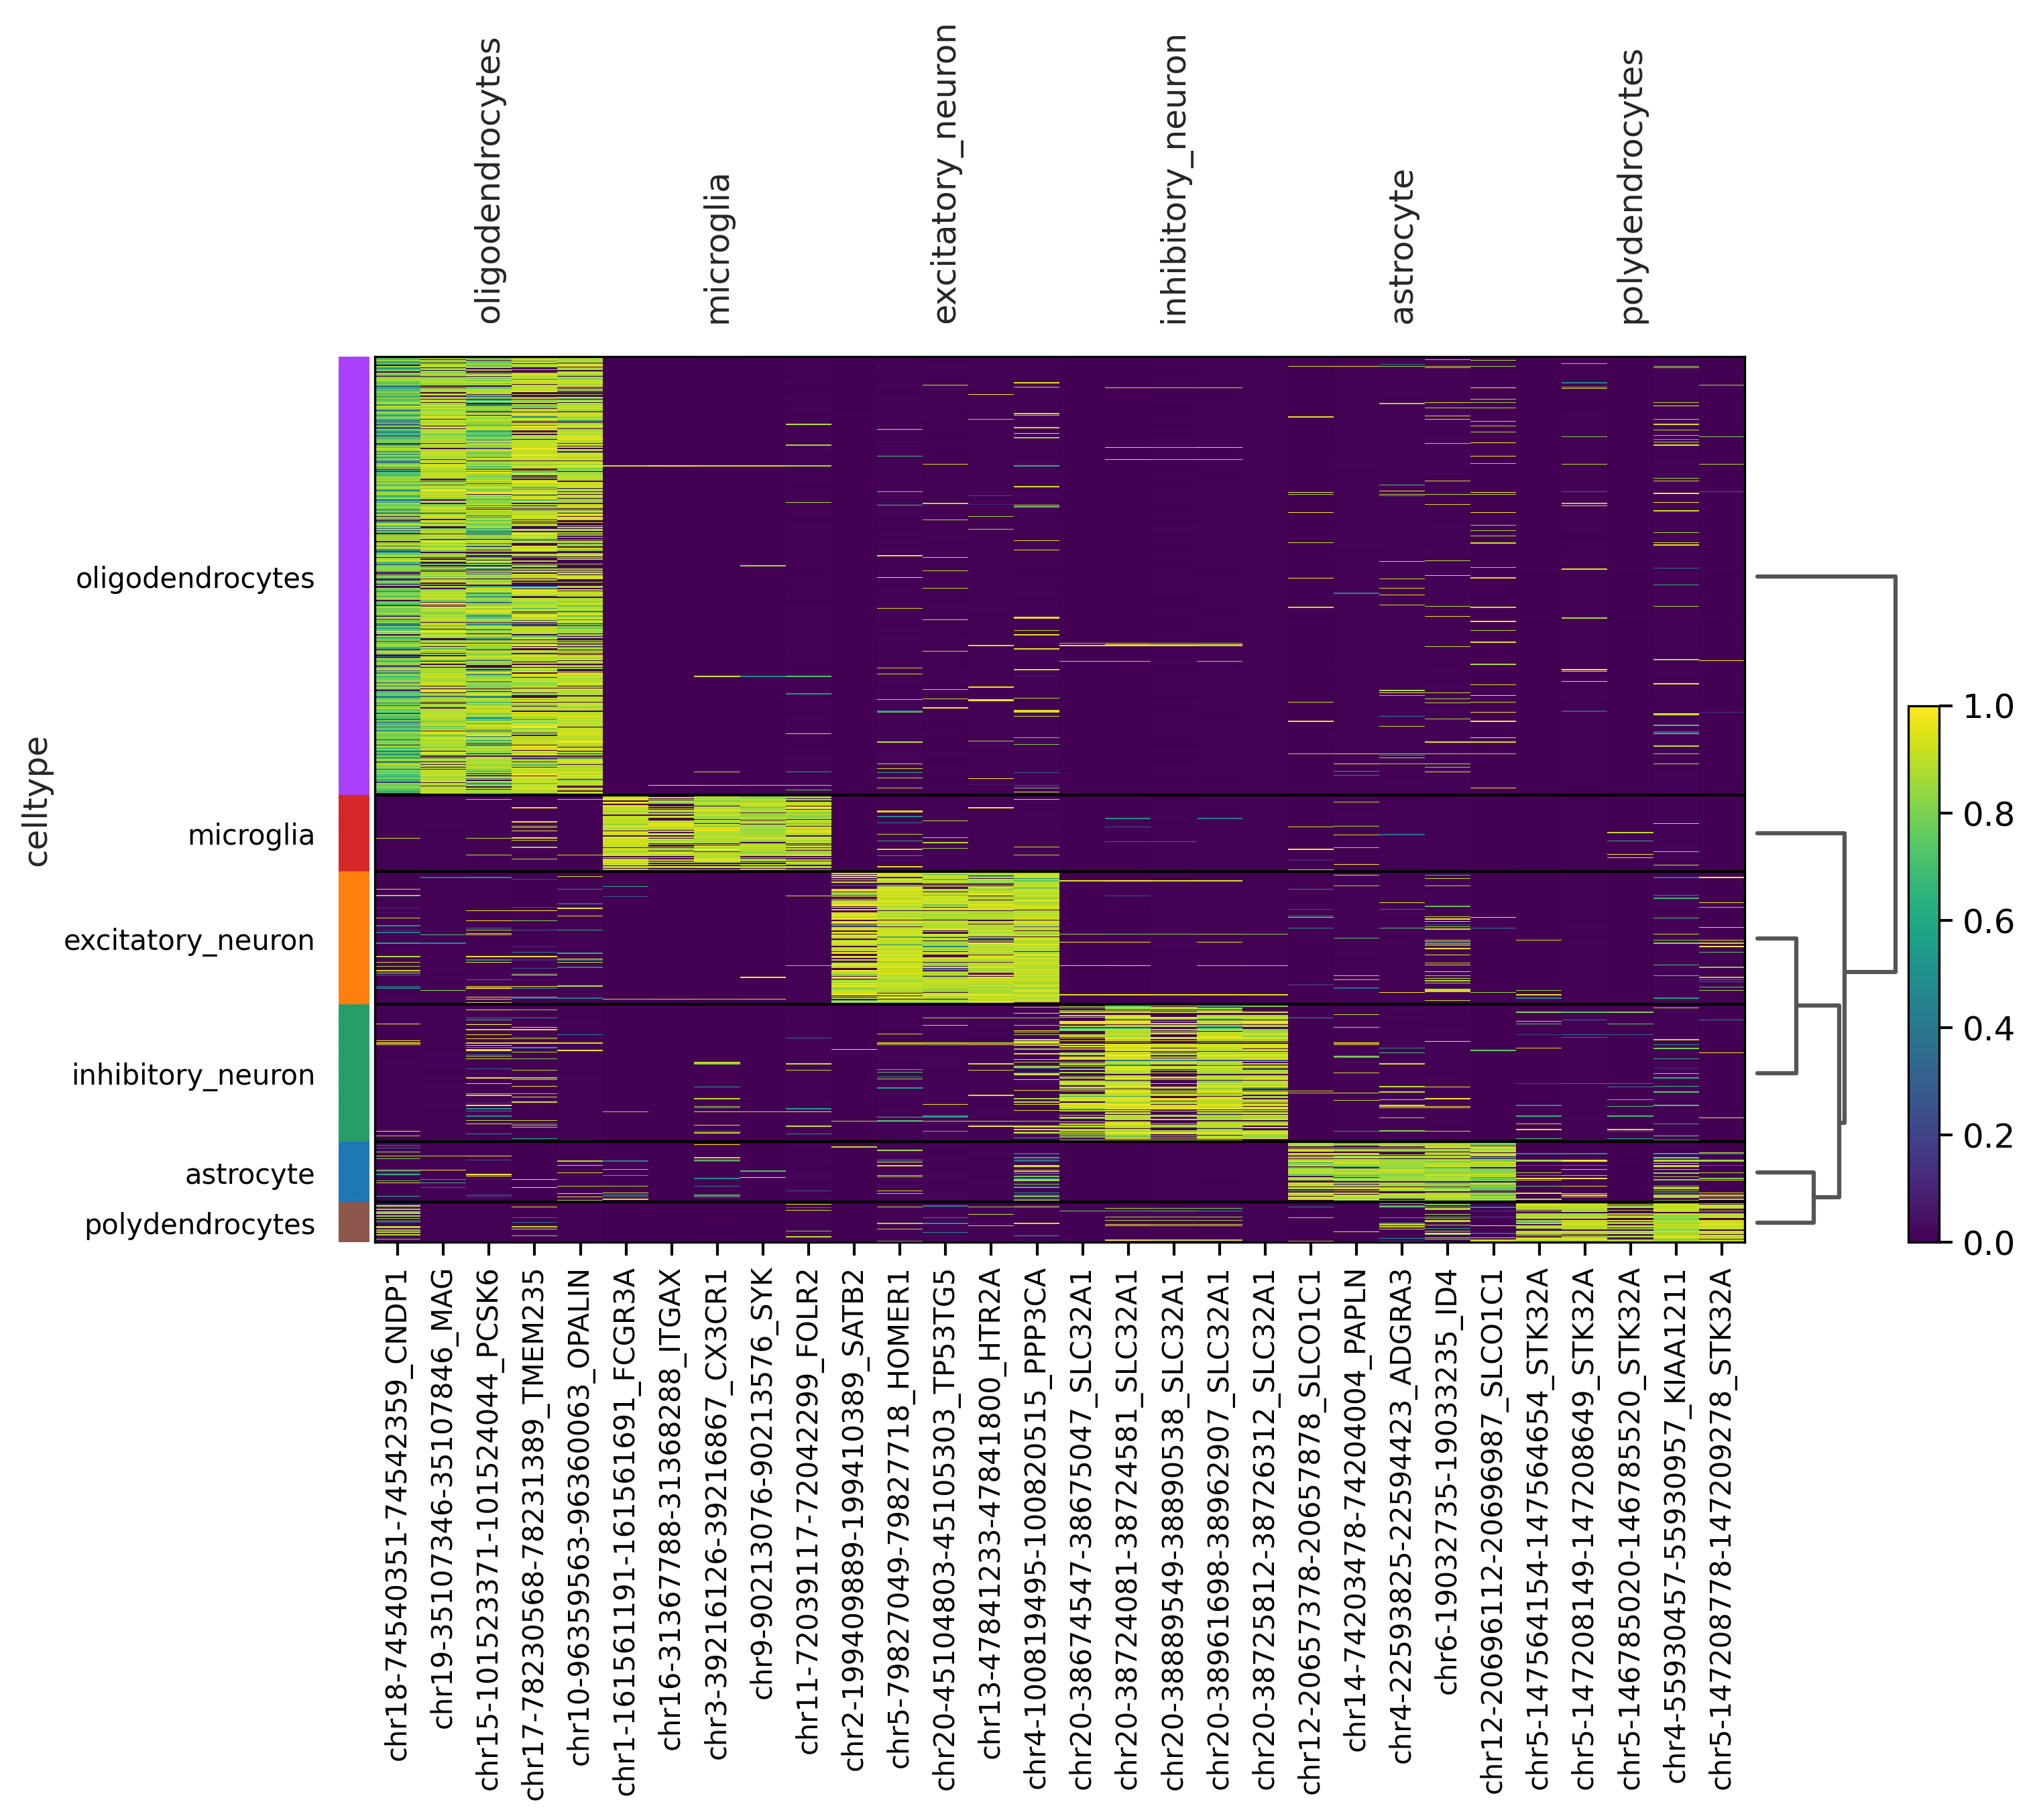


--- Section 4: Single Edge Detail View ---


In [5]:
import os
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ==========================================
# 0. Basic Settings & Data Preprocessing
# ==========================================

# Set plotting style
sc.settings.set_figure_params(dpi=150, frameon=False, facecolor='white', fontsize=12)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']

# Define paths (Adjust based on your environment)
data_dir = "./"
h5ad_path = os.path.join(data_dir, "MFG_RS_score.h5ad")

# Check if file exists
if not os.path.exists(h5ad_path):
    raise FileNotFoundError(f"[ERROR] Data file not found: {h5ad_path}")

print(f"Loading data from {h5ad_path}...")
adata = sc.read_h5ad(h5ad_path)

# [CRITICAL STEP] Extract target gene names from Edge IDs
# Assumed format: chr1-1432429-1432929_VWA1 -> Extract 'VWA1'
# If your format differs, adjust the split logic.
adata.var['target_gene'] = [x.split('_')[-1] for x in adata.var_names]

print("Data loaded and gene names extracted.")

# ==========================================
# 2. Gene-Centric Regulatory Activity (Dotplot)
# ==========================================
print("\n--- Section 2: Gene-Level Aggregation & Dotplot ---")

# 2.1 Define canonical marker genes (Brain cortex example)
marker_genes = {
    'Oligodendrocytes': ['MBP', 'MOG', 'PLP1', 'OLIG1'],
    'Microglia': ['C1QA', 'C1QB', 'CSF1R', 'CX3CR1'],
    'Astrocytes': ['AQP4', 'GFAP', 'ALDH1L1'],
    'Neurons': ['SNAP25', 'SYT1', 'RBFOX3'], 
    'Excitatory': ['SLC17A7', 'NEUROD6'],
    'Inhibitory': ['GAD1', 'GAD2']
}

# Flatten list for filtering
flat_markers = [g for cat in marker_genes.values() for g in cat]

# 2.2 Aggregate Edge scores to Gene level
# Logic: Find all edges pointing to Gene A, calculate the mean/sum score.
print("Aggregating edge scores to gene level...")

gene_scores_df = pd.DataFrame(index=adata.obs_names)

for gene in flat_markers:
    # Identify edges pointing to this gene
    edge_mask = adata.var['target_gene'] == gene
    
    if np.sum(edge_mask) > 0:
        # Extract scores
        scores = adata.X[:, edge_mask]
        if hasattr(scores, "toarray"):
            scores = scores.toarray()
        
        # Calculate mean regulatory intensity for this gene per cell
        gene_scores_df[gene] = scores.mean(axis=1) 

# Check for missing markers
found_genes = gene_scores_df.columns
missing_markers = set(flat_markers) - set(found_genes)
if missing_markers:
    print(f"[INFO] The following markers were not found in edge targets and will be excluded: {list(missing_markers)}")

# 2.3 Create a new AnnData object for gene-level scores
adata_gene = sc.AnnData(X=gene_scores_df.values, obs=adata.obs)
adata_gene.var_names = gene_scores_df.columns

# 2.4 Filter the dictionary for plotting
# Only keep genes that actually exist in the aggregated data
print("Filtering marker genes dictionary for plotting...")
marker_genes_filtered = {}
for cell_type, genes in marker_genes.items():
    existing_genes = [gene for gene in genes if gene in adata_gene.var_names]
    if existing_genes:
        marker_genes_filtered[cell_type] = existing_genes

# 2.5 Plot Dotplot
print("Plotting Gene-Level Regulatory Dotplot...")
plt.figure(figsize=(8, 6))
sc.pl.dotplot(
    adata_gene, 
    var_names=marker_genes_filtered, 
    groupby='celltype', 
    standard_scale='var',    # Normalize 0-1 across groups for better contrast
    title='Aggregated Regulatory Score of Marker Genes',
    cmap='RdBu_r',           # Red = High regulation
    swap_axes=True,          # Genes on Y-axis
    show=False
)
plt.tight_layout()
plt.show()

# ==========================================
# 3. Top Differential Regulatory Edges (Heatmap)
# ==========================================
print("\n--- Section 3: Differential Edge Analysis ---")

print("Calculating differential edges (Wilcoxon rank-sum)...")
sc.tl.rank_genes_groups(adata, 'celltype', method='wilcoxon')

# Plot Heatmap
plt.figure(figsize=(8, 10))
sc.pl.rank_genes_groups_heatmap(
    adata, 
    n_genes=5,                  # Top 5 edges per cell type
    groupby='celltype', 
    cmap='viridis', 
    standard_scale='var', 
    show_gene_labels=True,      # Show Edge IDs
    show=False
)
plt.tight_layout()
plt.show()

# ==========================================
# 4. Specific Edge Deep Dive (Boxplot)
# ==========================================
print("\n--- Section 4: Single Edge Detail View ---")

def plot_top_edge_for_gene(target_gene, adata_obj, palette=None):
    """
    Finds the most active edge for a specific gene and plots its distribution.
    """
    # 1. Find all edges for the gene
    gene_vars = adata_obj.var[adata_obj.var['target_gene'] == target_gene]
    if len(gene_vars) == 0:
        print(f"[WARN] Gene {target_gene} not found in edges.")
        return

    # 2. Find the "best" edge (e.g., highest max signal across dataset)
    edge_indices = [adata_obj.var_names.get_loc(idx) for idx in gene_vars.index]
    
    X_subset = adata_obj.X[:, edge_indices]
    if hasattr(X_subset, "toarray"): 
        X_subset = X_subset.toarray()
    
    # Strategy: Pick the edge with the highest maximum value
    max_scores = X_subset.max(axis=0)
    best_idx_local = np.argmax(max_scores)
    best_edge_name = gene_vars.index[best_idx_local]
    
    print(f"Plotting top edge for {target_gene}: {best_edge_name}")

    # 3. Prepare data for plotting
    plot_df = pd.DataFrame({
        'Regulatory Score': X_subset[:, best_idx_local],
        'Cell Type': adata_obj.obs['celltype'].values
    })
    # 4. Plot
    plt.figure(figsize=(6, 4))
    sns.boxplot(
        x='Cell Type', 
        y='Regulatory Score', 
        data=plot_df, 
        palette=palette,
        showfliers=False
    )
    plt.title(f"Most Active Regulatory Element for {target_gene}\n({best_edge_name})", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    sns.despine(trim=True)
    plt.tight_layout()
    plt.show()

# Define palette (ensure keys match your celltype names in metadata)


Plotting top edge for MBP: chr18-76801959-76802520_MBP


/tmp/ipykernel_23671/2263826392.py:165: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


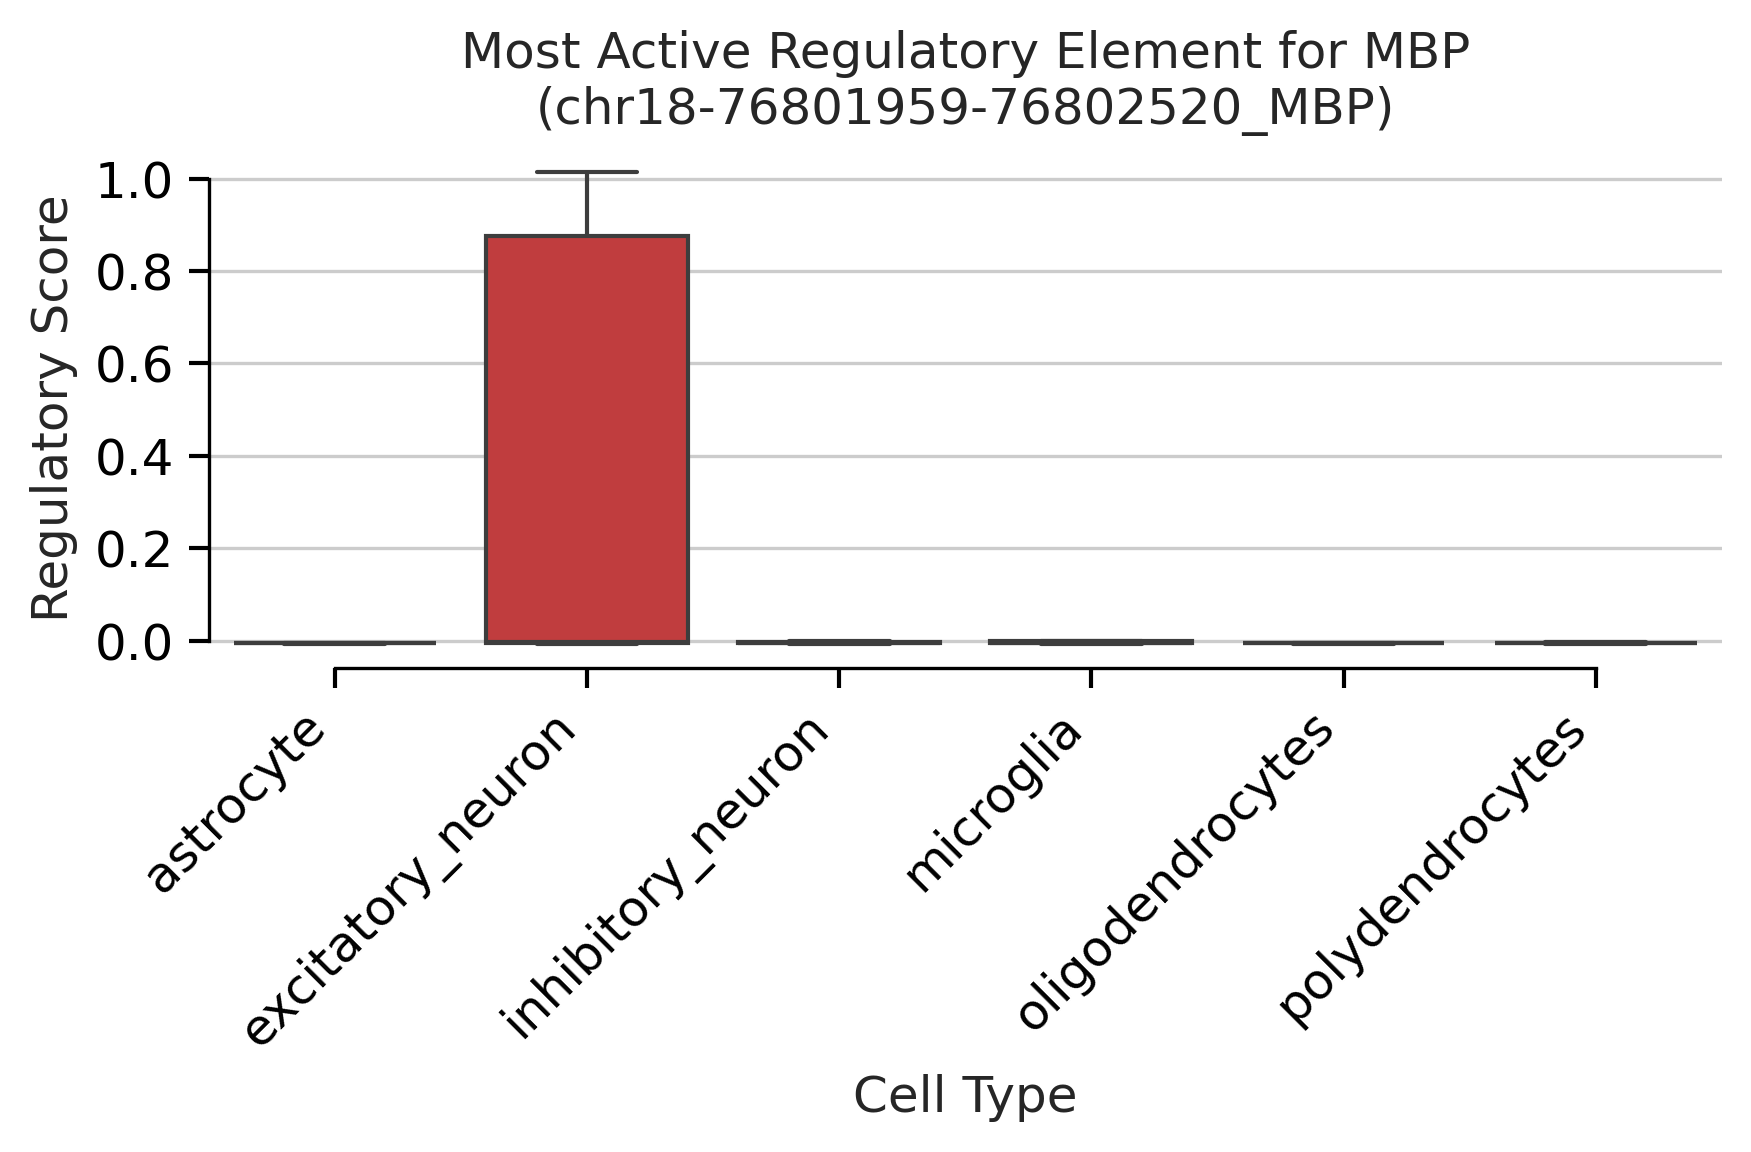

Plotting top edge for PLP1: chrX-103776630-103777130_PLP1


/tmp/ipykernel_23671/2263826392.py:165: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


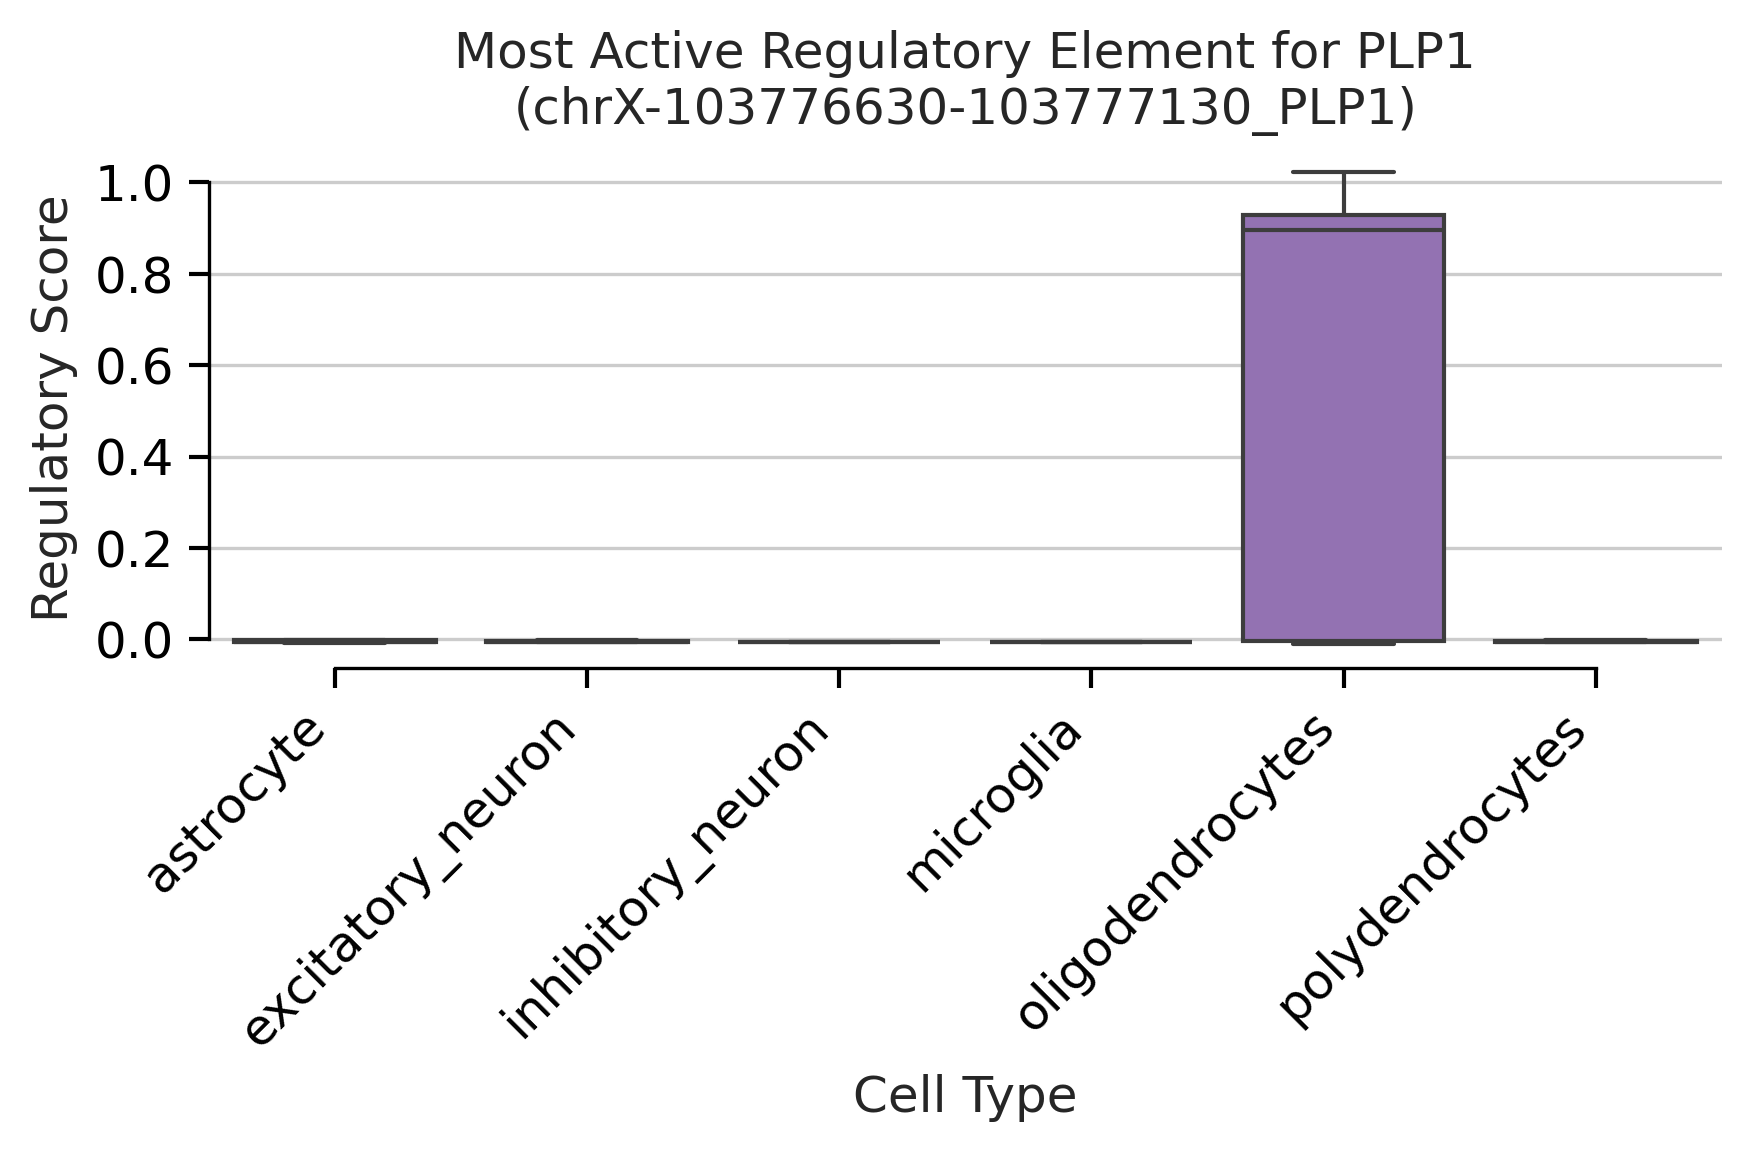

In [6]:
my_palette2 = {
    'oligodendrocytes': '#9467bd',
    'neurons': '#ff7f0e',
    'microglia': '#2ca02c',
    'astrocyte': '#1f77b4',
    'polydendrocytes': '#e377c2',
    'unknown': '#7f7f7f',
    'excitatory_neuron': '#d62728',   # red tone
    'inhibitory_neuron': '#17becf'    # cyan tone
}
# Example Usage
plot_top_edge_for_gene('MBP', adata, palette=my_palette2)
plot_top_edge_for_gene('PLP1', adata, palette=my_palette2)

--- Computing Global Statistics (Mean & Std) ---
--- Extracting Network for: microglia (Z-score=True) ---


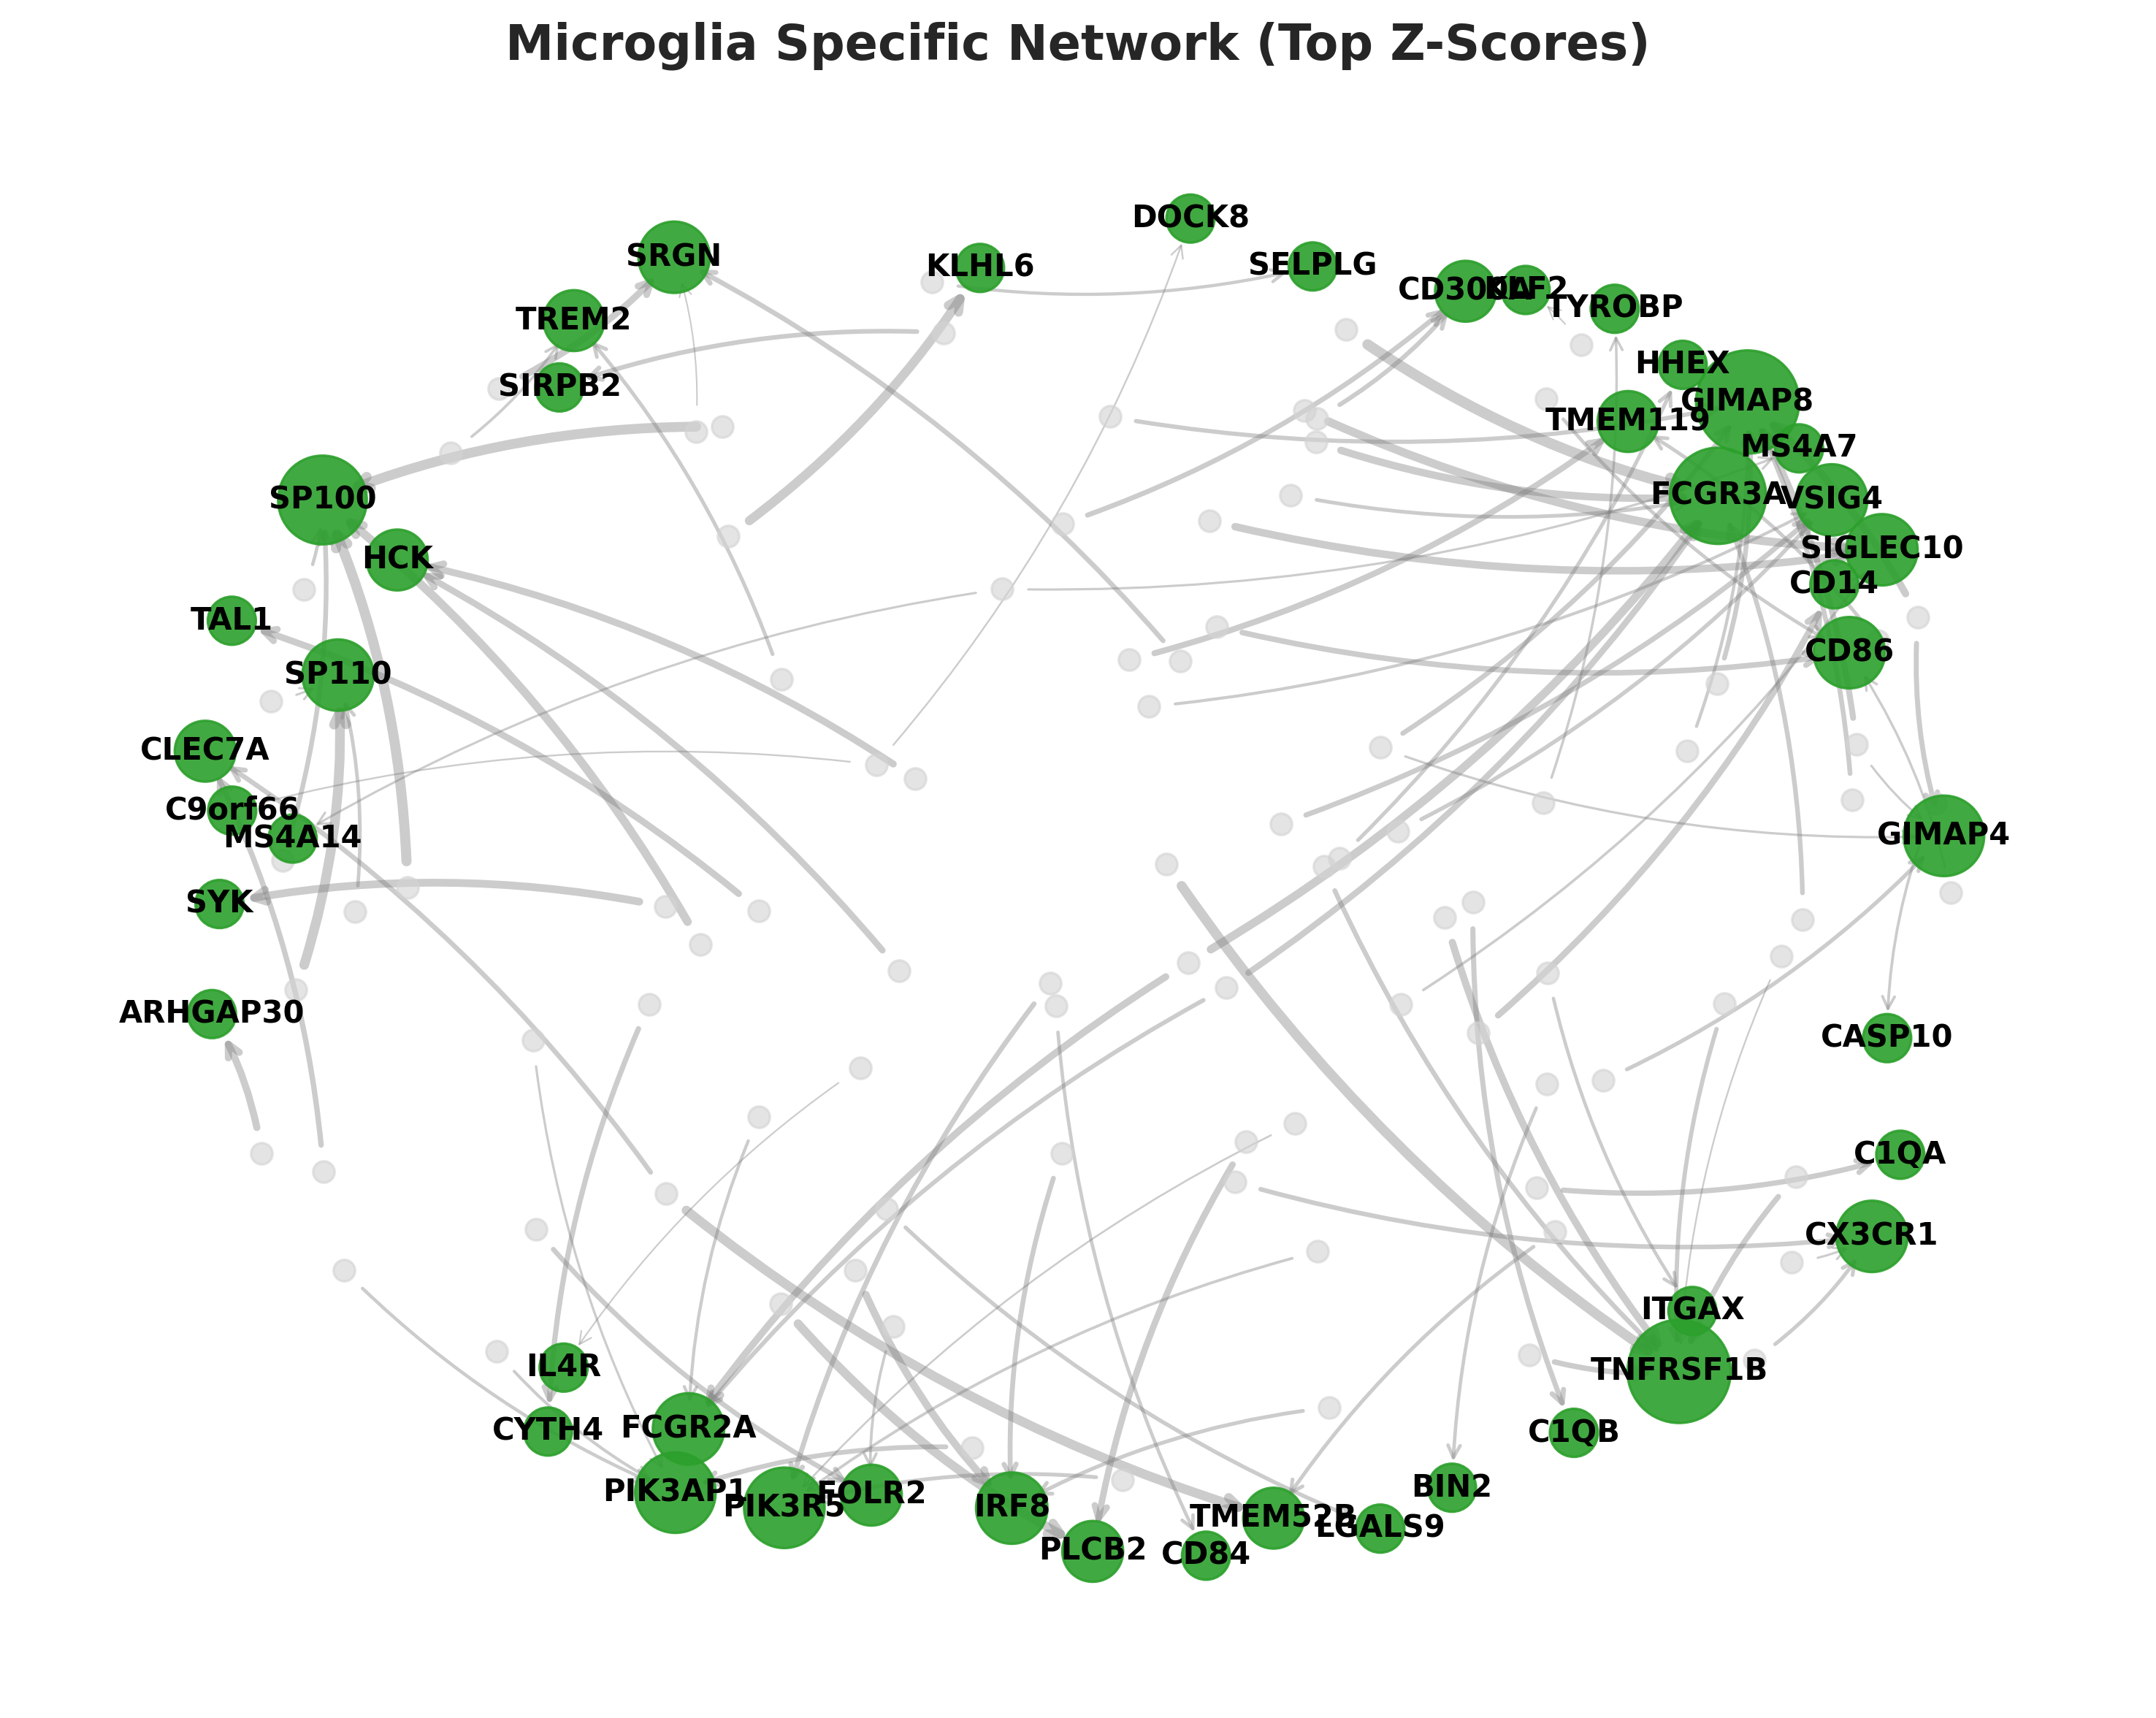

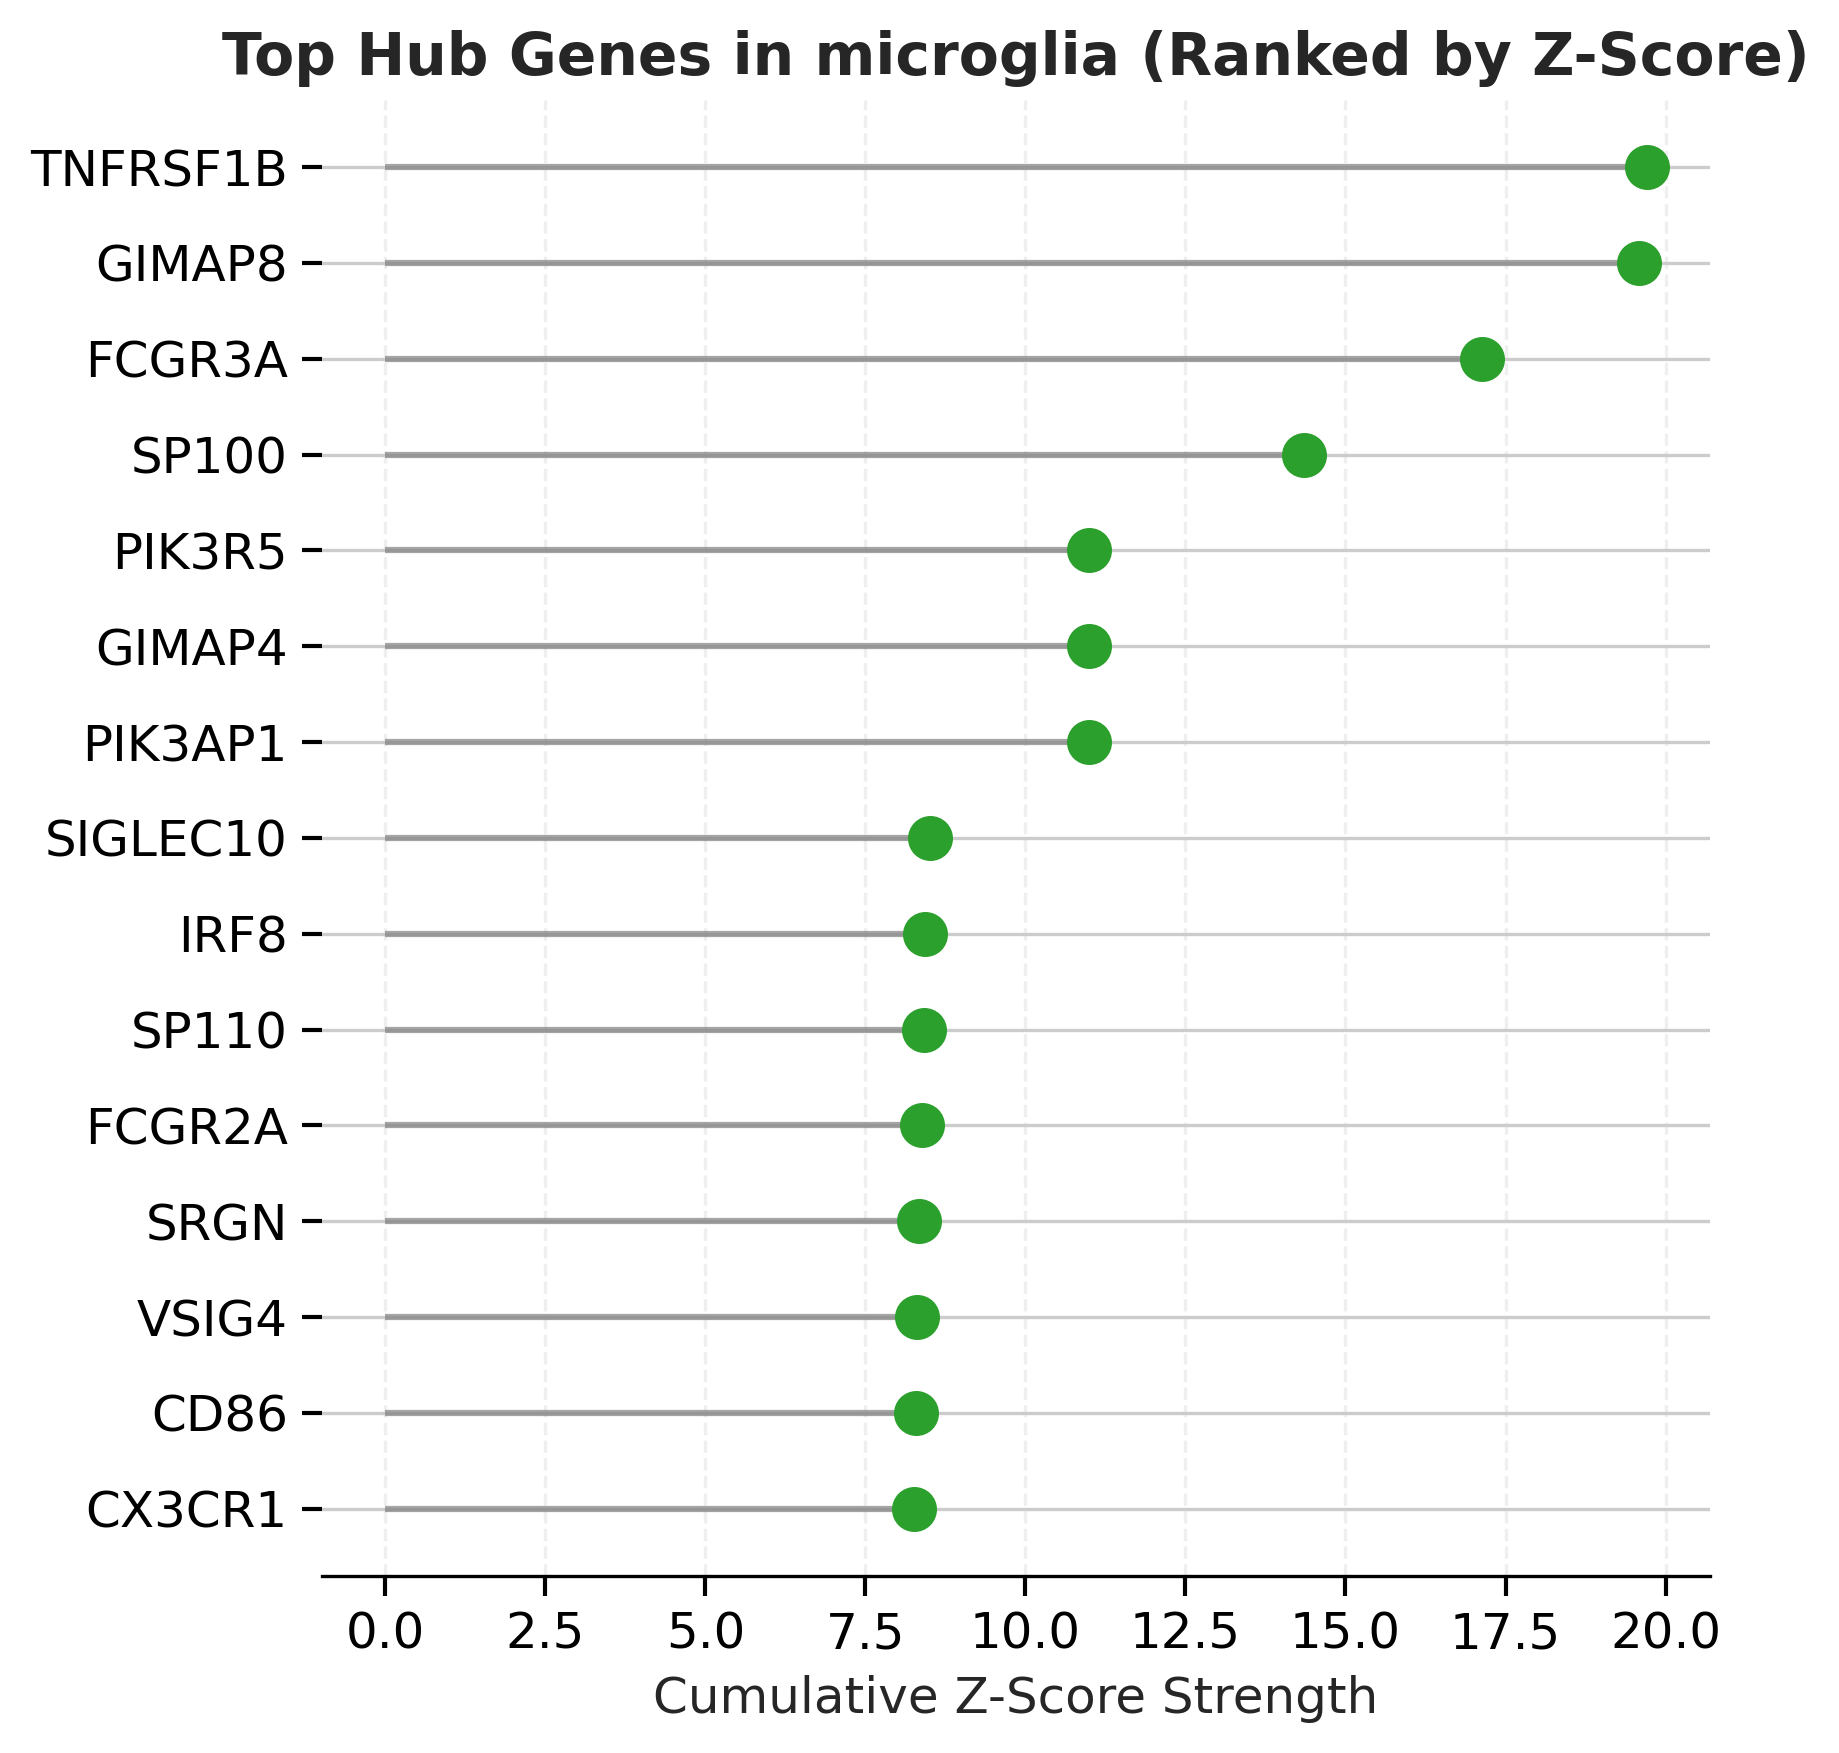

--- Extracting Network for: astrocyte (Z-score=True) ---


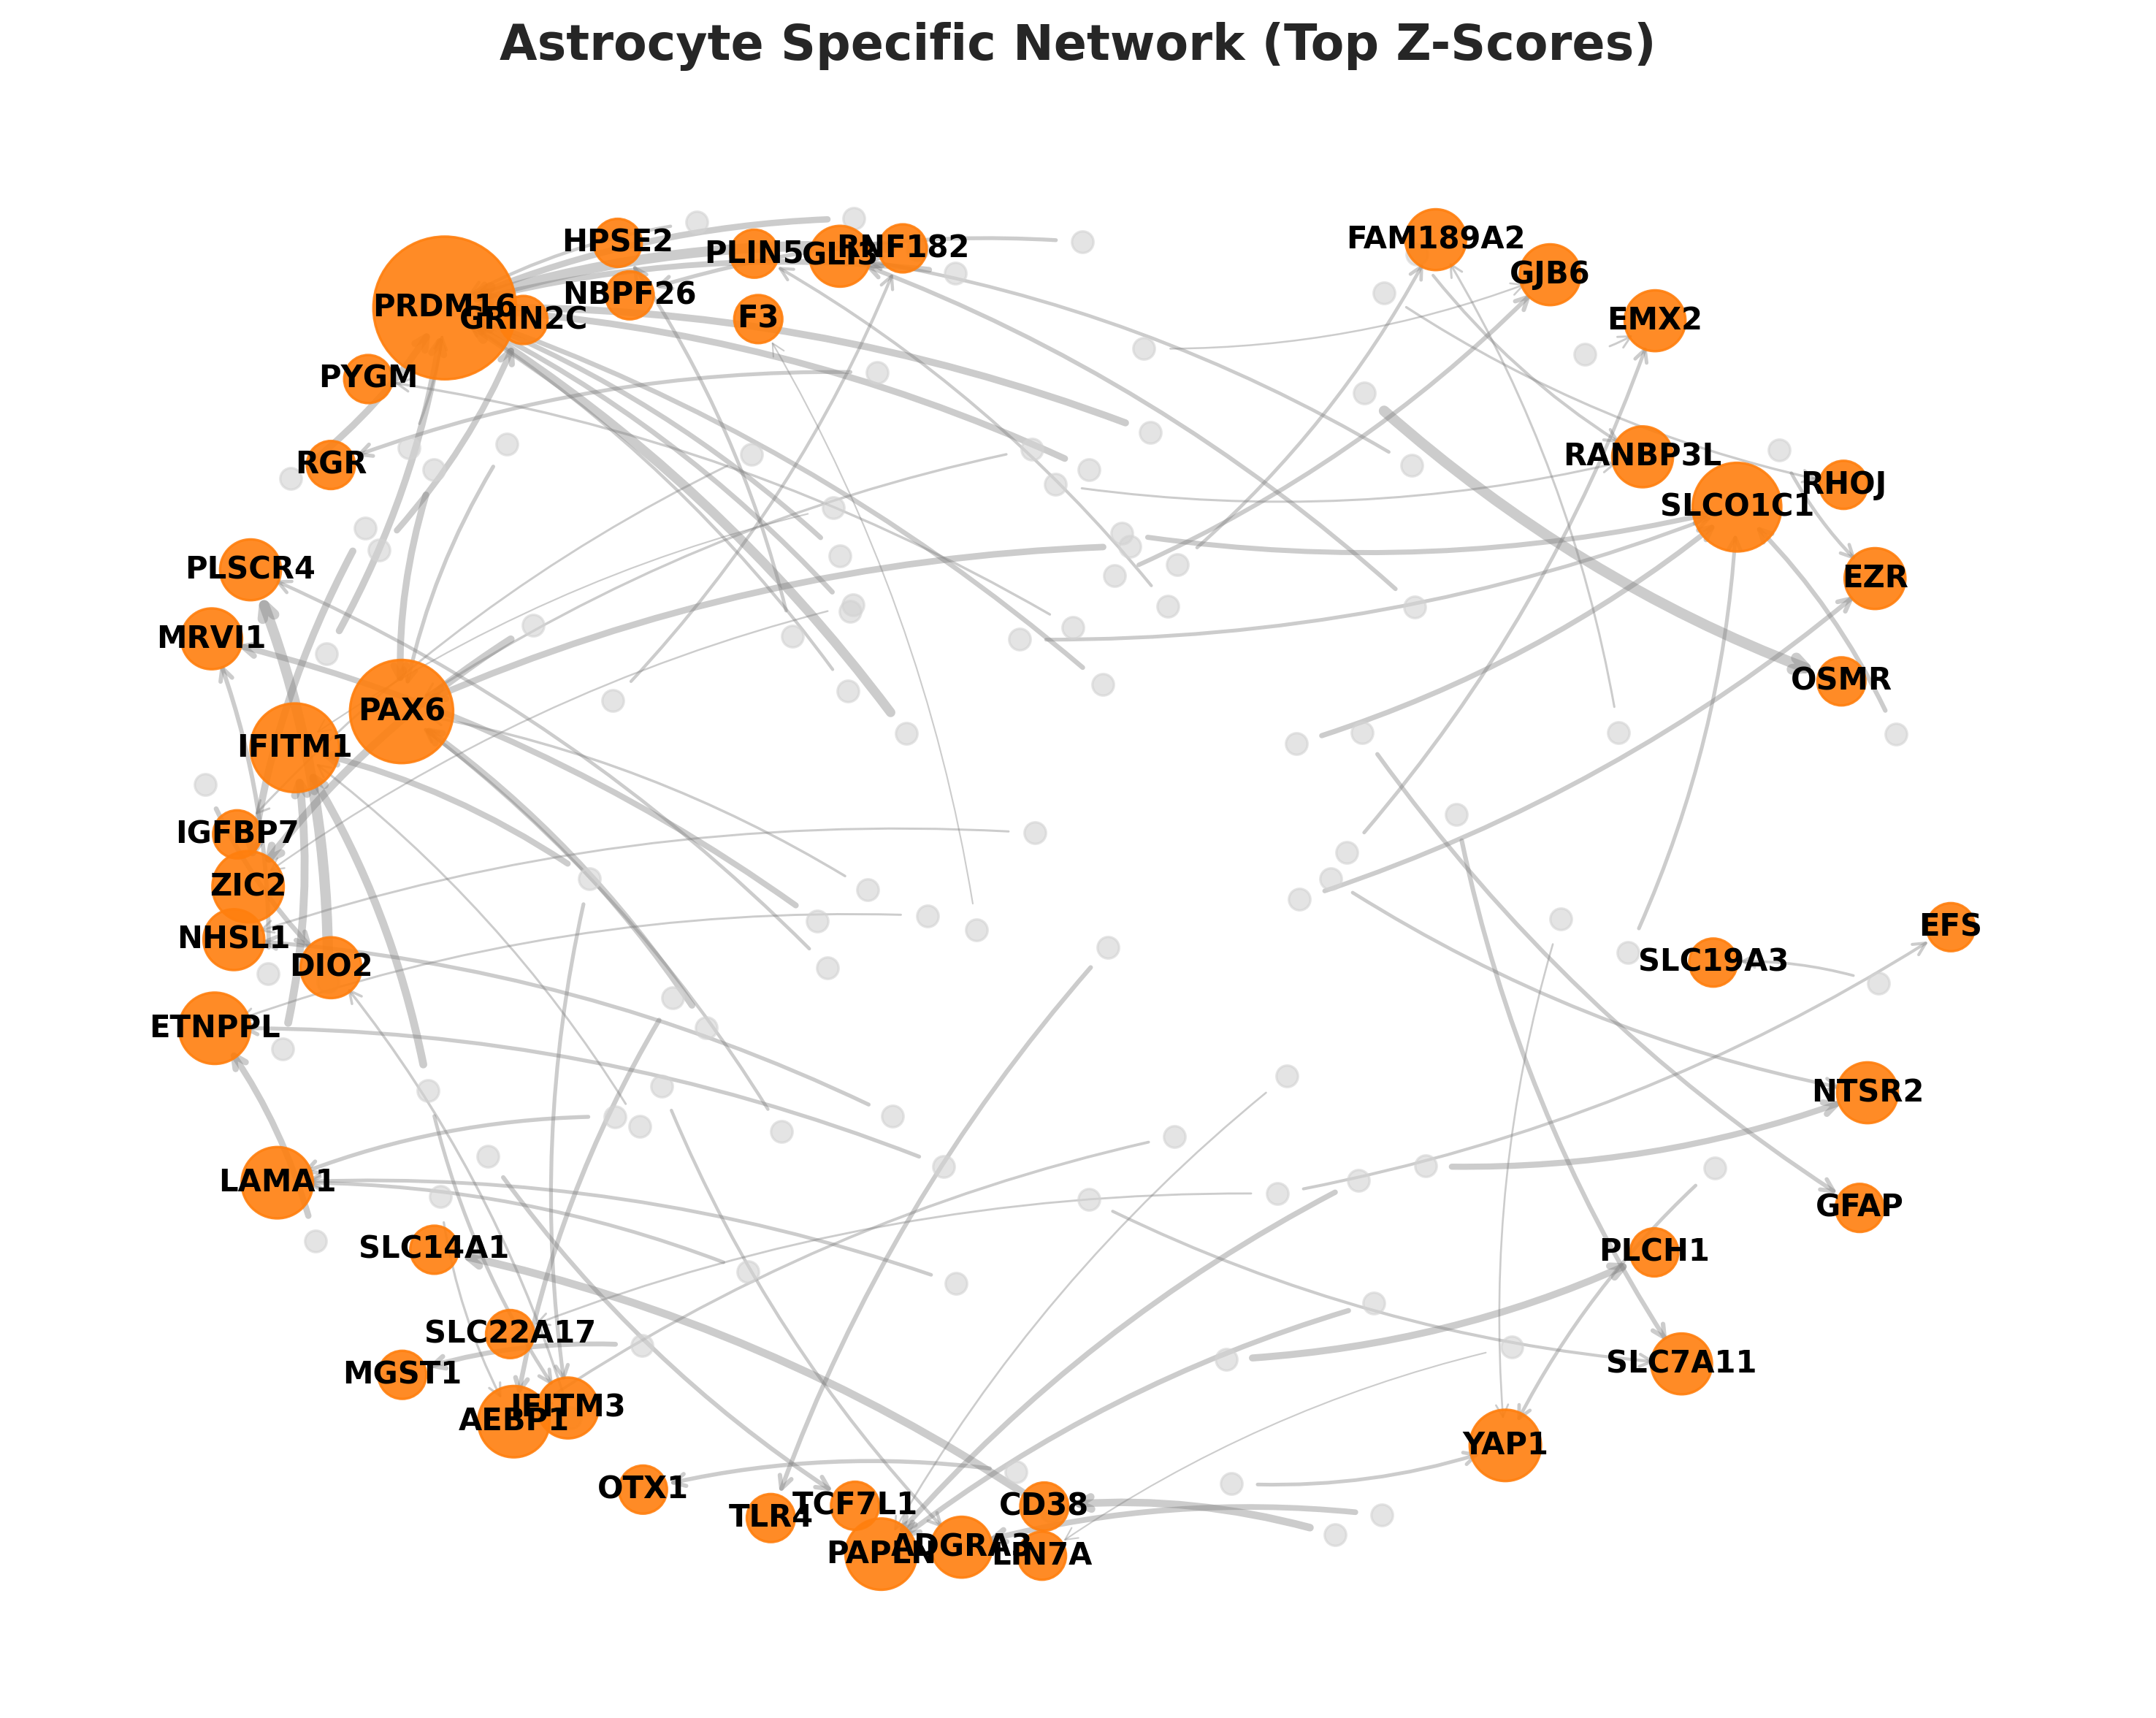

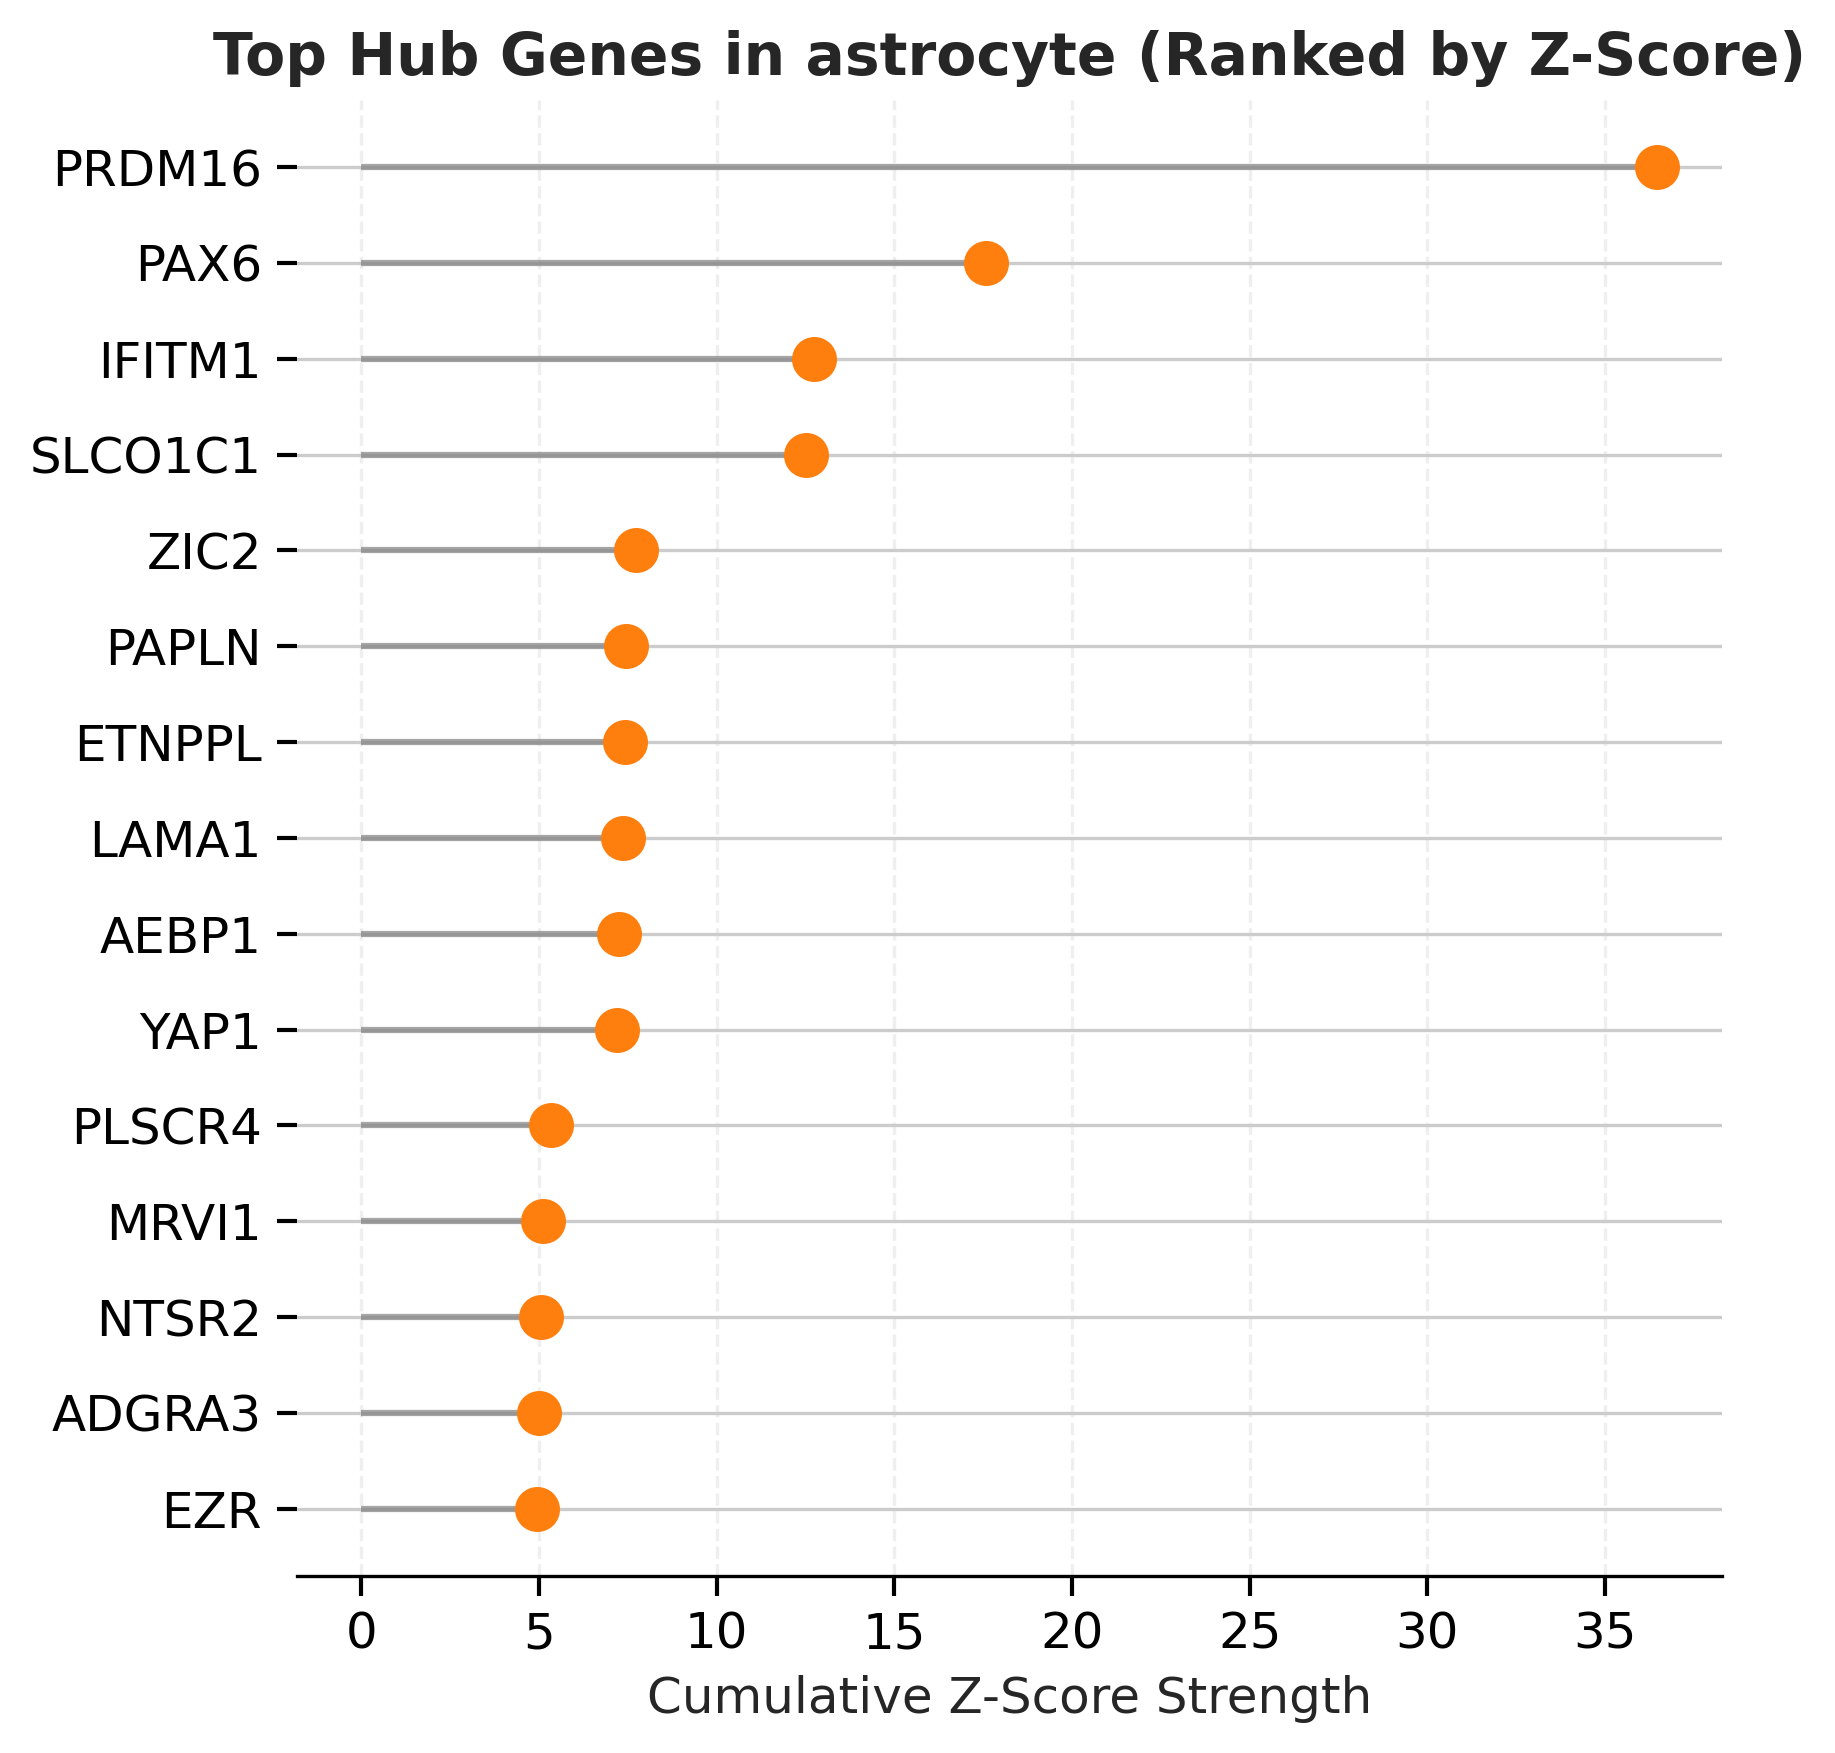

In [13]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse

# ==========================================
# 1. Advanced Setup: Pre-calculate Global Stats
# ==========================================

def prepare_global_stats(adata):
    """
    Pre-calculate global Mean and Std to enable fast Z-scoring
    without densifying the whole matrix.
    """
    print("--- Computing Global Statistics (Mean & Std) ---")
    
    # Calculate Mean and Std across all cells (axis=0)
    # Using Scanpy's sparse-friendly methods
    if sparse.issparse(adata.X):
        # mean is a matrix type, flatten it to array
        mean_global = np.array(adata.X.mean(axis=0)).flatten()
        
        # Calculate std efficiently: E[X^2] - (E[X])^2
        # (Simplified approximation for speed, or use simple loop if memory allows)
        # Here we use a safe distinct method for sparse matrices
        # Calculation of exact std on sparse matrix can be tricky, 
        # let's use a robust approximation or direct calculation if RAM permits.
        
        # Method: Calculate variance
        mean_sq = adata.X.multiply(adata.X).mean(axis=0)
        mean_sq = np.array(mean_sq).flatten()
        var_global = mean_sq - mean_global**2
        std_global = np.sqrt(np.clip(var_global, 1e-10, None)) # Avoid division by zero
    else:
        mean_global = np.mean(adata.X, axis=0)
        std_global = np.std(adata.X, axis=0)
        
    return mean_global, std_global

# ==========================================
# 2. Network Extraction (Now with Z-Score!)
# ==========================================

def get_top_edges_for_celltype(adata, cell_type, global_stats, n_top_edges=100, use_zscore=True):
    """
    Extract the top N edges.
    If use_zscore=True, ranks edges by their specificity (Z-score) relative to global average.
    """
    print(f"--- Extracting Network for: {cell_type} (Z-score={use_zscore}) ---")
    
    mean_global, std_global = global_stats
    
    # 1. Select cells
    cells_mask = adata.obs['celltype'] == cell_type
    if not np.any(cells_mask):
        print(f"No cells found for {cell_type}")
        return None

    # 2. Calculate Subset Mean (Raw Strength)
    X_subset = adata[cells_mask].X
    mean_subset = np.array(X_subset.mean(axis=0)).flatten()
    
    # 3. Compute Scores
    if use_zscore:
        # Smart Z-score calculation: (Subset_Mean - Global_Mean) / Global_Std
        # This tells us: How many standard deviations is this group above the average?
        final_scores = (mean_subset - mean_global) / (std_global + 1e-9)
    else:
        final_scores = mean_subset
    
    # 4. Find Top Indices
    # argsort sorts ascending, we take the last N
    top_indices = np.argsort(final_scores)[-n_top_edges:][::-1]
    
    # 5. Build DataFrame
    top_edges = adata.var_names[top_indices]
    top_vals = final_scores[top_indices]
    
    df_net = pd.DataFrame({
        'edge_name': top_edges,
        'weight': top_vals
    })
    
    # Parse Peak_Gene
    df_net['target'] = df_net['edge_name'].apply(lambda x: x.split('_')[-1])
    df_net['source'] = df_net['edge_name'].apply(lambda x: "_".join(x.split('_')[:-1]))
    
    return df_net

# ==========================================
# 3. Plotting Functions (Updated Labels)
# ==========================================

def plot_beautiful_network(df_edges, cell_type, color_theme='#1f77b4'):
    if df_edges is None or df_edges.empty: return

    G = nx.DiGraph()
    for _, row in df_edges.iterrows():
        # Ensure weight is positive for width calculation if Z-score is used
        w = max(row['weight'], 0.1) 
        G.add_edge(row['source'], row['target'], weight=w)

    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, k=0.6, seed=42, iterations=50)
    
    targets = list(set(df_edges['target']))
    sources = list(set(df_edges['source']))
    d = dict(G.degree)
    
    # Draw Nodes
    nx.draw_networkx_nodes(G, pos, nodelist=sources, node_color='lightgrey', 
                           node_size=50, alpha=0.6, label='Peak')
    nx.draw_networkx_nodes(G, pos, nodelist=targets, node_color=color_theme, 
                           node_size=[d[t]*150 + 100 for t in targets], alpha=0.9, label='Gene')

    # Draw Edges
    weights = [G[u][v]['weight'] for u,v in G.edges()]
    # Normalize for visual thickness (handle potential negative Z-scores if filtering logic changes)
    min_w, max_w = min(weights), max(weights)
    width_norm = [(w - min_w)/(max_w - min_w + 1e-9) * 3 + 0.5 for w in weights]
    
    nx.draw_networkx_edges(G, pos, width=width_norm, alpha=0.4, edge_color='grey',
                           connectionstyle="arc3,rad=0.1", arrowstyle='->', arrowsize=10)

    # Labels
    nx.draw_networkx_labels(G, pos, {n:n for n in targets}, font_size=10, font_weight='bold')

    plt.title(f"{cell_type.capitalize()} Specific Network (Top Z-Scores)", fontsize=16, weight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_hub_genes(df_edges, cell_type, palette_color):
    # Summing Z-scores implies "Total Specificity"
    hub_df = df_edges.groupby('target')['weight'].sum().sort_values(ascending=True).reset_index()
    
    if len(hub_df) > 15: hub_df = hub_df.tail(15)

    plt.figure(figsize=(6, 6))
    plt.hlines(y=hub_df['target'], xmin=0, xmax=hub_df['weight'], color='grey', alpha=0.7)
    plt.scatter(hub_df['weight'], hub_df['target'], color=palette_color, s=100, zorder=3)
    
    plt.title(f"Top Hub Genes in {cell_type} (Ranked by Z-Score)", fontsize=14, weight='bold')
    plt.xlabel("Cumulative Z-Score Strength", fontsize=12)
    sns.despine(left=True)
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

# ==========================================
# 4. Execution
# ==========================================

if 'adata' in locals():
    # A. Pre-calculate global stats (Run ONCE)
    global_mean, global_std = prepare_global_stats(adata)
    global_stats_tuple = (global_mean, global_std)
    
    analysis_targets = {
        'microglia': '#2ca02c', 
        'astrocyte': '#ff7f0e'  
    }

    for c_type, color in analysis_targets.items():
        # B. Get Z-Score based Top Edges
        # use_zscore=True ensures we find SPECIFIC edges, not just generally strong ones
        network_df = get_top_edges_for_celltype(adata, c_type, global_stats_tuple, 
                                                n_top_edges=100, use_zscore=True)
    
        if network_df is not None:
            plot_beautiful_network(network_df, c_type, color_theme=color)
            plot_hub_genes(network_df, c_type, palette_color=color)
else:
    print("adata not found.")